In [1]:
from IPython.core.display import HTML
HTML(open('custom.css', 'r').read())

# Spicing It Up! (Sorry)

[SKiDL](https://xesscorp.github.io/skidl/docs/_site/index.html) is a Python package for describing the interconnection of electronic devices using text (instead of schematics). [PySpice](https://pyspice.fabrice-salvaire.fr/) is an interface for controlling an external SPICE circuit simulator from Python. This document demonstrates how circuits described using SKiDL can be simulated under a variety of conditions using PySpice with the results displayed in an easily-shared [Jupyter](http://jupyter.org/) notebook.

![SKiDL + PyCircuit + ngspice + matplotlib data flow.](dataflow.png)

## Why?

There are existing SPICE simulators that analyze schematics created by CAD packages like KiCad.
There are also versions with their own GUI like LTSpice.
What advantages does a combination of SKiDL, PySpice and ngspice offer?

* The circuit description is completely textual, so it's easy to share with others who may not have a schematic editor or GUI.
* It can be archived in a Git repository for the purpose of tracking versions as modifications are made.
* The documentation of the circuitry is embedded with the circuitry, so it's more likely to be kept current.
* It makes the entire Python ecosystem of tools available for optimizing, analyzing, and visualizing the behavior of a circuit under a variety of conditions.

## Installation

For Ubuntu linux, first install ngspice:

    sudo apt-get update
    sudo apt-get install ngspice
    
If you're using Windows, [download ngspice](http://ngspice.sourceforge.net/experimental/ngspice-27_32.7z) and copy the `Spice` directory from the archive over to `C:\Program Files`.
    
Next, for either OS, install SKiDL:

    pip install skidl
    
This will also install PySpice.

## Examples

The following examples demonstrate some of the ways of using SKiDL and PySpice to simulate electronics. While shown using the Jupyter notebook, these examples will also work by placing the Python code into a file and executing it with a Python interpreter.

The following code snippet is needed at the beginning of every example.
It loads the `matplotlib` package for generating graphs, and SKiDL + PySpice packages for describing and simulating circuitry.

In [2]:
# Load the package for drawing graphs.
import matplotlib.pyplot as plt
# Omit the following line if you're not using a Jupyter notebook.
%matplotlib inline

# Load the SKiDL + PySpice packages and initialize them for doing circuit simulations.
from skidl.pyspice import *

### Current Through a Resistor

The following example connects a 1 K$\Omega$ resistor to a voltage source whose value is ramped from 0 to 1 volts.
The current through the resistor is plotted versus the applied voltage.


No errors or warnings found during netlist generation.

Note: can't find init file.


   V    I (mA)
  0.00  -0.00
  0.10   0.10
  0.20   0.20
  0.30   0.30
  0.40   0.40
  0.50   0.50
  0.60   0.60
  0.70   0.70
  0.80   0.80
  0.90   0.90
  1.00   1.00


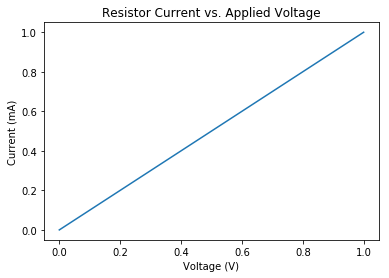

In [3]:
reset()  # This will clear any previously defined circuitry.

# Create and interconnect the components.
vs = V(ref='VS', dc_value = 1 @ u_V)  # Create a voltage source named "VS" with an initial value of 1 volt.
r1 = R(value = 1 @ u_kOhm)            # Create a 1 Kohm resistor.
vs['p'] += r1[1]       # Connect one end of the resistor to the positive terminal of the voltage source.
gnd += vs['n'], r1[2]  # Connect the other end of the resistor and the negative terminal of the source to ground.

# Simulate the circuit.
circ = generate_netlist()              # Translate the SKiDL code into a PyCircuit Circuit object.
sim = circ.simulator()                 # Create a simulator for the Circuit object.
dc_vals = sim.dc(VS=slice(0, 1, 0.1))  # Run a DC simulation where the voltage ramps from 0 to 1V by 0.1V increments.

# Get the voltage applied to the resistor and the current coming out of the voltage source.
voltage = dc_vals[node(vs['p'])].as_ndarray()  # Get the voltage applied by the positive terminal of the source.
current = -dc_vals['VS'].as_ndarray()  # Get the current coming out of the positive terminal of the voltage source.

# Print a table showing the current through the resistor for the various applied voltages.
print('{:^7s}{:^7s}'.format('V', ' I (mA)'))
print('='*15)
for v, i in zip(voltage, current*1000):
    print('{:6.2f} {:6.2f}'.format(v, i))

# Create a plot of the current (Y coord) versus the applied voltage (X coord).
figure = plt.figure(1)
plt.title('Resistor Current vs. Applied Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.plot(voltage, 1000*current) # Plot X=voltage and Y=current (in milliamps, so multiply it by 1000).
plt.show()

### Transient Response of an R-C Filter

This example shows the time-varying voltage of a capacitor charged through a resistor by a pulsed voltage source.


No errors or warnings found during netlist generation.



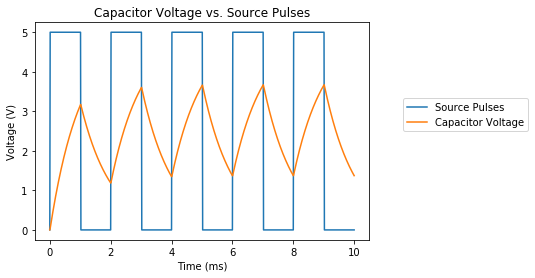

In [4]:
reset()  # Clear out the existing circuitry from the previous example.

# Create a pulsed voltage source, a resistor, and a capacitor.
vs = PULSEV(initial_value=0, pulsed_value=5@u_V, pulse_width=1@u_ms, period=2@u_ms)  # 1ms ON, 1ms OFF pulses.
r = R(value=1@u_kOhm)    # 1 Kohm resistor.
c = C(value=1@u_uF)      # 1 uF capacitor.
r[1,2] += vs['p'], c[1]  # Connect the resistor between the positive source terminal and one of the capacitor terminals.
gnd += vs['n'], c[2]     # Connect the negative battery terminal and the other capacitor terminal to ground.

# Simulate the circuit.
circ = generate_netlist()            # Create the PySpice Circuit object from the SKiDL code.
sim = circ.simulator()               # Get a simulator for the Circuit object.
waveforms = sim.transient(step_time=0.01@u_ms, end_time=10@u_ms)  # Run a transient simulation from 0 to 10 msec.

# Get the simulation data.
time = waveforms.time.as_ndarray()                # Time values for each point on the waveforms.
pulses = waveforms[node(vs['p'])].as_ndarray()    # Voltage on the positive terminal of the pulsed voltage source.
cap_voltage = waveforms[node(c[1])].as_ndarray()  # Voltage on the capacitor.

# Plot the pulsed source and capacitor voltage values versus time.
figure = plt.figure(1)
plt.title('Capacitor Voltage vs. Source Pulses')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.plot(time*1000, pulses)       # Plot pulsed source waveform.
plt.plot(time*1000, cap_voltage)  # Plot capacitor charging waveform.
plt.legend(('Source Pulses', 'Capacitor Voltage'), loc=(1.1, 0.5))
plt.show()

### A Voltage-Controlled Voltage Source

A voltage source whose output is controlled by another voltage source is demonstrated in this example.


No errors or warnings found during netlist generation.

Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.9944E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.9986E-03 Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   9.9996E-03 Warning: singular matrix:  check nodes v1#branch and n2
Note: Starting source stepping
Supplies reduced to   0.0000% Warning: singular matrix:  check nodes v1#branch and n2
Trying gmin =   1.0000E-02 Warning: singul

.title 
E1 N1 0 N2 0 2.5
R1 N2 0 1kOhm
R2 N1 0 1kOhm
V1 N1 0 DC 0V AC SIN(0V 1V 100Hz 0s 0Hz)



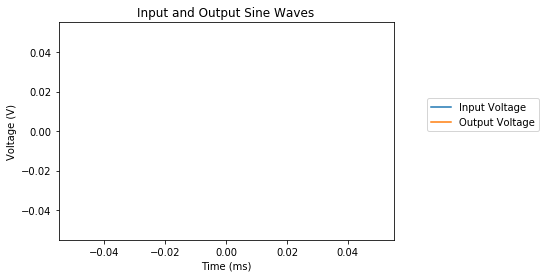

In [5]:
reset()  # Clear out the existing circuitry from the previous example.

# Connect a sine wave to the control input of a voltage-controlled voltage source.
vs = SINEV(amplitude=1@u_V, frequency=100@u_Hz)  # 1V sine wave source at 100 Hz.
vs['n'] += gnd  # Connect the negative terminal of the sine wave to ground.
vc = VCVS(gain=2.5)  # Voltage-controlled voltage source with a gain of 2.5.
vc['ip', 'in'] += vs['p'], gnd  # Connect the sine wave to the input port of the controlled source.
vc['op', 'on'] += Net(), gnd    # Connect the output port of the controlled source to a net and ground.
rl = R(value=1@u_kOhm)
rl[1,2] += vc['op'], gnd
r = R(value=1@u_kOhm)
r[1,2] += vs['p'], gnd

# Simulate the circuit.
circ = generate_netlist()  # Create the PySpice Circuit object from the SKiDL code.
print(circ)
sim = circ.simulator()  # Get a simulator for the Circuit object.
waveforms = sim.transient(step_time=0.01@u_ms, end_time=20@u_ms) # Run a transient simulation from 0 to 20 msec.

# Get the time-varying waveforms of the sine wave source and the voltage-controlled source.
time = waveforms.time.as_ndarray()
vin = waveforms[node(vs['p'])].as_ndarray()
vout = waveforms[node(vc['op'])].as_ndarray()

# Plot the input and output waveforms. Note that the output voltage is 2.5x the input voltage.
figure = plt.figure(1)
plt.title('Input and Output Sine Waves')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.plot(time*1000, vin)
plt.plot(time*1000, vout)
plt.legend(('Input Voltage', 'Output Voltage'), loc=(1.1, 0.5))
plt.show()

### A Current-Controlled Current Source

This example shows a current source controlled by the current driven through a resistor by a voltage source.


No errors or warnings found during netlist generation.



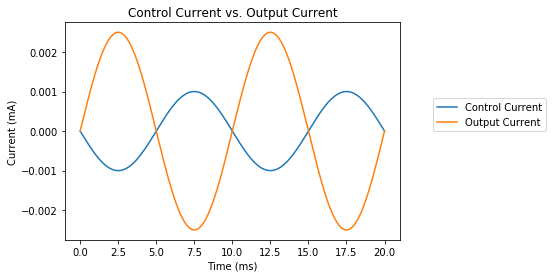

In [6]:
reset()  # Clear out the existing circuitry from the previous example.

# Use the current driven through a resistor to control another current source.
vs = SINEV(amplitude=1@u_V, frequency=100@u_Hz) # 100 Hz sine wave voltage source.
rs = R(value=1@u_kOhm)  # Resistor connected to the voltage source.
rs[1,2] += vs['p'], gnd  # Connect resistor from positive terminal of voltage source to ground.
vs['n'] += gnd  # Connect the negative terminal of the voltage source to ground.
vc = CCCS(control=vs, gain=2.5)  # Current source controlled by the current entering the vs voltage source.
rc = R(value=1@u_Ohm)  # Resistor connected to the current source.
rc[1,2] += vc['p'], gnd  # Connect resistor from the positive terminal of the current source to ground.
vc['n'] += gnd  # Connect the negative terminal of the current source to ground.

# Simulate the circuit.
circ = generate_netlist()
sim = circ.simulator()
waveforms = sim.transient(step_time=0.01@u_ms, end_time=20@u_ms)

# Get the time-varying waveforms of the currents from the sine wave source and the current-controlled current source.
time = waveforms.time
i_vs = waveforms[vs.ref]
i_vc = waveforms[node(rc[1])] / rc.value  # Current-source current is the voltage across the resistor / resistance.

# Plot the waveforms. Note the input and output currents are out of phase since the output current is calculated
# based on the current *leaving* the positive terminal of the controlled current source and entering the resistor, 
# whereas the current in the controlling voltage source is calculated based on what is *entering* the positive terminal.
figure = plt.figure(1)
plt.title('Control Current vs. Output Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.plot(time*1000, i_vs)
plt.plot(time*1000, i_vc)
plt.legend(('Control Current', 'Output Current'), loc=(1.1, 0.5))
plt.show()

### A Transmission Line

The voltages at the beginning and end of an ideal transmission line are shown in this example.


No errors or warnings found during netlist generation.



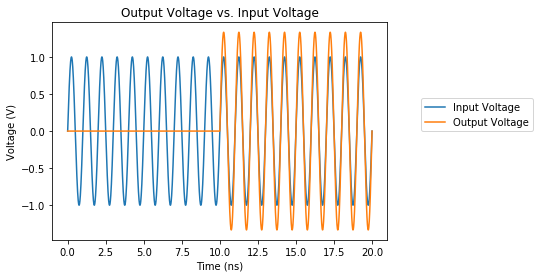

In [7]:
reset()  # Clear out the existing circuitry from the previous example.

# Create a 1 GHz sine wave source, drive it through a 70 ohm ideal transmission line, and terminate it with a 140 ohm resistor.
vs = SINEV(amplitude=1@u_V, frequency=1@u_GHz)
t1 = T(impedance=70@u_Ohm, frequency=1@u_GHz, normalized_length=10.0) # Trans. line is 10 wavelengths long.
rload = R(value=140@u_Ohm)
vs['p'] += t1['ip']  # Connect source to positive input terminal of trans. line.
rload[1] += t1['op'] # Connect resistor to positive output terminal of trans. line.
gnd += vs['n'], t1['in','on'], rload[2] # Connect remaining terminals to ground.

# Simulate the transmission line.
circ = generate_netlist()
sim = circ.simulator()
waveforms = sim.transient(step_time=0.01@u_ns, end_time=20@u_ns)

# Get the waveforms at the beginning and end of the trans. line.
time = waveforms.time * 10**9
vin = waveforms[node(vs['p'])]      # Input voltage at the beginning of the trans. line.
vout = waveforms[node(rload['1'])]  # Output voltage at the terminating resistor of the trans. line.

# Plot the input and output waveforms. Note that it takes 10 nsec for the input to reach the end of the
# transmission line, and there is a 33% "bump" in the output voltage due to the mismatch between the
# 140 ohm load resistor and the 70 ohm transmission line impedances.
figure = plt.figure(1)
plt.title('Output Voltage vs. Input Voltage')
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (V)')
plt.plot(time, vin)
plt.plot(time, vout)
plt.legend(('Input Voltage', 'Output Voltage'), loc=(1.1, 0.5))
plt.show()

### A Transistor Amplifier

The use of SPICE models is demonstrated in this example of a common-emitter transistor amplifier.
For this example, a subdirectory called `SpiceLib` was created with a single file `2N2222A.lib` that holds
the `.MODEL` statement for that particular type of transistor.

Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004

.title 
.include C:\xesscorp\KiCad\tools\skidl\examples\spice-sim-intro\SpiceLib\2N2222A.lib
Q1 N1 N2 0 2n2222a
R1 N4 N2 5kOhm
R2 N2 N3 25kOhm
R3 N1 N3 1kOhm
V1 N3 0 5V
V2 N4 0 DC 0V AC SIN(0V 0.01V 1kHz 0s 0Hz)



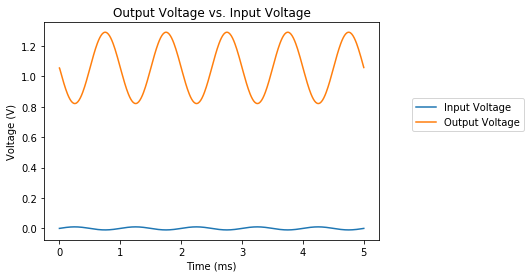

In [8]:
reset()  # Clear out the existing circuitry from the previous example.

# Create a transistor, power supply, bias resistors, collector resistor, and an input sine wave source.
q = BJT(model='2n2222a')    # 2N2222A NPN transistor. The model is stored in a directory of SPICE .lib files.
vdc = V(dc_value=5@u_V)     # 5V power supply.
rs = R(value=5@u_kOhm)      # Source resistor in series with sine wave input voltage.
rb = R(value=25@u_kOhm)     # Bias resistor from 5V to base of transistor.
rc = R(value=1@u_kOhm)      # Load resistor connected to collector of transistor.
vs = SINEV(amplitude=0.01@u_V, frequency=1@u_kHz)  # 1 KHz sine wave input source.
q['c', 'b', 'e'] += rc[1], rb[1], gnd  # Connect transistor CBE pins to load & bias resistors and ground.
vdc['p'] += rc[2], rb[2]    # Connect other end of load and bias resistors to power supply's positive terminal.
vdc['n'] += gnd             # Connect negative terminal of power supply to ground.
rs[1,2] += vs['p'], q['b']  # Connect source resistor from input source to base of transistor.
vs['n'] += gnd              # Connect negative terminal of input source to ground.

# Simulate the transistor amplifier. This requires a SPICE library containing a model of the 2N2222A transistor.
circ = generate_netlist(libs='SpiceLib')  # Pass the directory to the SPICE model library when creating circuit.
print(circ)
sim = circ.simulator() 
waveforms = sim.transient(step_time=0.01@u_ms, end_time=5@u_ms)

# Get the input source and amplified output waveforms.
time = waveforms.time
vin = waveforms[node(vs['p'])]  # Input source voltage.
vout = waveforms[node(q['c'])]  # Amplified output voltage at collector of the transistor.

# Plot the input and output waveforms.
figure = plt.figure(1)
plt.title('Output Voltage vs. Input Voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.plot(time*1000, vin)
plt.plot(time*1000, vout)
plt.legend(('Input Voltage', 'Output Voltage'), loc=(1.1, 0.5))
plt.show()

### A Hierarchical Circuit

SKiDL lets you describe a circuit inside a function, and then call that function to create hierarchical designs that can be analyzed with SPICE. This example defines a simple transistor inverter and then cascades several of them.

Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004

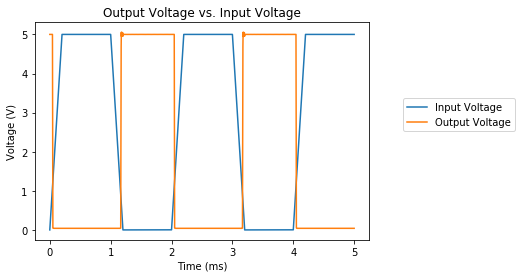

In [9]:
reset()  # You know what this does by now, right?

# Create a power supply for all the following circuitry.
pwr = V(dc_value=5@u_V)
pwr['n'] += gnd
vcc = pwr['p']

# Create a logic inverter using a transistor and a few resistors.
@subcircuit
def inverter(inp, outp):
    '''When inp is driven high, outp is pulled low by transistor. When inp is driven low, outp is pulled high by resistor.'''
    q = BJT(model='2n2222a')  # NPN transistor.
    rc = R(value=1@u_kOhm)    # Resistor attached between transistor collector and VCC.
    rc[1,2] += vcc, q['c']    
    rb = R(value=10@u_kOhm)   # Resistor attached between transistor base and input.
    rb[1,2] += inp, q['b']
    q['e'] += gnd             # Transistor emitter attached to ground.
    outp += q['c']            # Inverted output comes from junction of the transistor collector and collector resistor.
    
# Create a pulsed voltage source to drive the input of the inverters. I set the rise and fall times to make
# it easier to distinguish the input and output waveforms in the plot.
vs = PULSEV(initial_value=0, pulsed_value=5@u_V, pulse_width=0.8@u_ms, period=2@u_ms, rise_time=0.2@u_ms, fall_time=0.2@u_ms)  # 1ms ON, 1ms OFF pulses.
vs['n'] += gnd

# Create three inverters and cascade the output of one to the input of the next.
outp = Net() * 3  # Create three nets to attach to the outputs of each inverter.
inverter(vs['p'], outp[0])  # First inverter is driven by the pulsed voltage source.
inverter(outp[0], outp[1])  # Second inverter is driven by the output of the first.
inverter(outp[1], outp[2])  # Third inverter is driven by the output of the second.

# Simulate the cascaded inverters.
circ = generate_netlist(libs='SpiceLib') # Pass-in the library where the transistor model is stored.
sim = circ.simulator()
waveforms = sim.transient(step_time=0.01@u_ms, end_time=5@u_ms)

# Get the waveforms for the input and output.
time = waveforms.time
inp = waveforms[node(vs['p'])]
outp = waveforms[node(outp[2])]  # Get the output waveform for the final inverter in the cascade.

# Plot the input and output waveforms. The output will be the inverse of the input since it passed
# through three inverters.
figure = plt.figure(1)
plt.title('Output Voltage vs. Input Voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.plot(time*1000, inp)
plt.plot(time*1000, outp)
plt.legend(('Input Voltage', 'Output Voltage'), loc=(1.1, 0.5))
plt.show()

### Using SPICE Subcircuits

There are many electronic components whose behavior is captured in *subcircuits* stored in SPICE library files.
These subcircuits can be used in SKiDL code as shown below.

In [10]:
reset()
lib_search_paths[SPICE].append('C:\Program Files (x86)\LTC\LTspiceIV\lib')
vin = V(dc_value=5@u_V)  # Input power supply
splib = SchLib('lt1083')
vreg = Part(splib, 'lt1084-3.3')  # Voltage regulator.
r = R(value=470 @ u_Ohm)
print(vreg)
vreg['IN', 'OUT'] += vin['p'], r[1]
gnd += vin['n'], r[2], vreg['GND']
print(gnd)
print(vreg['IN'].net)
print(vreg['OUT'].net)
circ = generate_netlist()

Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 N006 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004 N002 0 PA
Q1 N003 2 1 0 N temp=27
Q3 3 N002 2 0 NP
Q7 3 N003 N004 0 NA
Q12 2 N004


 LT1084-3.3 (): 5A Low Dropout Positive Regulator, Fixed 3.3V Output
    Pin X1/1/GND/UNSPECIFIED
    Pin X1/2/OUT/UNSPECIFIED
    Pin X1/3/IN/UNSPECIFIED
0: Pin C1/2/n/PASSIVE, Pin E1/2/in/PASSIVE, Pin E1/4/on/PASSIVE, Pin F1/2/n/PASSIVE, Pin None/2/in/PASSIVE, Pin None/2/in/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/2/n/PASSIVE, Pin None/3/E/PASSIVE, Pin None/3/E/PASSIVE, Pin None/4/on/PASSIVE, Pin None/4/on/PASSIVE, Pin Q1/3/E/PASSIVE, Pin Q1/3/E/PASSIVE, Pin Q2/3/E/PASSIVE, Pin Q3/3/E/PASSIVE, Pin R1/2/n/PASSIVE, Pin R1/2/n/PASSIVE, Pin R1/2/n/PASSIVE, Pin R1/2/n/PASSIVE, Pin R1/2/n/PASSIVE, Pin R2/2/n/PASSIVE, Pin R2/2/n/PASSIVE, Pin T1/2/in/PASSIVE, Pin T1/4/on/PASSIVE, Pin V1/2/n/PASSIVE, Pin V1/2/n/


No errors or warnings found during netlist generation.



## The Details

The examples section gave you some idea of what the combination of SKiDL, PySpice, ngspice, and matplotlib can do.
You should read the stand-alone documentation for each of those packages to get the full extent of their capabilities.
This section will address the features and functions that come in to play at their intersection.

### Units

You may have noticed the use of units in the examples above, such as `10 @ u_kOhm` to denote a resistance of 10 K$\Omega$.
This is a feature of the PySpice package. If you want to see all the available units, just do this:

In [11]:
import PySpice.Unit
', '.join(dir(PySpice.Unit))

'Frequency, FrequencyValue, FrequencyValues, Period, PeriodValue, PeriodValues, SiUnits, U_A, U_Bq, U_C, U_Degree, U_F, U_GA, U_GBq, U_GC, U_GDegree, U_GF, U_GGy, U_GH, U_GHz, U_GJ, U_GK, U_GN, U_GOhm, U_GPa, U_GS, U_GSv, U_GV, U_GW, U_GWb, U_Gcd, U_Gkat, U_Glm, U_Glx, U_Gm, U_Gmol, U_Grad, U_Gs, U_Gsr, U_Gy, U_GΩ, U_H, U_Hz, U_J, U_K, U_MA, U_MBq, U_MC, U_MDegree, U_MF, U_MGy, U_MH, U_MHz, U_MJ, U_MK, U_MN, U_MOhm, U_MPa, U_MS, U_MSv, U_MV, U_MW, U_MWb, U_Mcd, U_Mkat, U_Mlm, U_Mlx, U_Mm, U_Mmol, U_Mrad, U_Ms, U_Msr, U_MΩ, U_N, U_Ohm, U_Pa, U_S, U_Sv, U_TA, U_TBq, U_TC, U_TDegree, U_TF, U_TGy, U_TH, U_THz, U_TJ, U_TK, U_TN, U_TOhm, U_TPa, U_TS, U_TSv, U_TV, U_TW, U_TWb, U_Tcd, U_Tkat, U_Tlm, U_Tlx, U_Tm, U_Tmol, U_Trad, U_Ts, U_Tsr, U_TΩ, U_V, U_W, U_Wb, U_cd, U_kA, U_kBq, U_kC, U_kDegree, U_kF, U_kGy, U_kH, U_kHz, U_kJ, U_kK, U_kN, U_kOhm, U_kPa, U_kS, U_kSv, U_kV, U_kW, U_kWb, U_kat, U_kcd, U_kkat, U_klm, U_klx, U_km, U_kmol, U_krad, U_ks, U_ksr, U_kΩ, U_lm, U_lx, U_m, U_mA, U_mBq, U

The following units are the ones you'll probably use most:

* Potential: `u_TV` (terravolt), `u_GV` (gigavolt), `u_MV` (megavolt), `u_kV` (kilovolt), `u_V` (volt), `u_mV` (millivolt), `u_uV` (microvolt), `u_nV` (nanovolt), `u_pV` (picovolt).
* Current: `u_TA` (terraamp), `u_GA` (gigaamp), `u_MA` (megaamp), `u_kA` (kiloamp), `u_A` (amp), `u_mA` (milliamp), `u_uA` (microamp), `u_nA` (nanoamp), `u_pA` (picoamp).
* Resistance: `u_TOhm` (terraohm), `u_GOhm` (gigaohm), `u_MOhm` (megaohm), `u_kOhm` (kiloohm), `u_Ohm` (ohm), `u_mOhm` (milliohm), `u_uOhm` (microohm), `u_nOhm` (nanoohm), `u_pOhm` (picoohm).
* Capacitance: `u_TF` (terrafarad) `u_GF` (gigafarad), `u_MF` (megafarad), `u_kF` (kilofarad), `u_F` (farad), `u_mF` (millifarad), `u_uF` (microfarad), `u_nF` (nanofarad), `u_pF` (picofarad).
* Inductance: `u_TH` (terrahenry), `u_GH` (gigahenry), `u_MH` (megahenry), `u_kH` (kilohenry), `u_H` (henry), `u_mH` (millihenry), `u_uH` (microhenry), `u_nH` (nanohenry), `u_pH` (picohenry).
* Time: `u_Ts` (terrasecond), `u_Gs` (gigasecond), `u_Ms` (megasecond), `u_ks` (kilosecond), `u_s` (second), `u_ms` (millisecond), `u_us` (microsecond), `u_ns` (nanosecond), `u_ps` (picosecond).
* Frequency: `u_THz` (terrahertz), `u_GHz` (gigahertz), `u_MHz` (megahertz), `u_kHz` (kilohertz), `u_Hz` (hertz), `u_mHz` (millihertz), `u_uHz` (microhertz), `u_nHz` (nanohertz), `u_pHz` (picohertz).

### Available Parts

The following is a list of parts (and their aliases) that are available for use in a SPICE simulation.
Many parts (like resistors) have only two pins denoted `p` and `n`, while some parts (like transmission lines)
have two *ports* composed of pins `ip`, `in` (the input port) and `op`, `on` (the output port).
The parts also have *attributes* that modify their characteristics.
These attributes can be set when a part is instantiated:

    r = R(value=1@u_kOhm)
    
or they can be set after instantiation like this:

    r.value = 1 @ u_kOhm

You can go [here](https://bwrcs.eecs.berkeley.edu/Classes/IcBook/SPICE/UserGuide/elements_fr.html)
for more information about what device characteristics the attributes control.

In [12]:
from skidl.libs.pyspice_sklib import pyspice_lib

for part in pyspice_lib.parts:
    print('{name} ({aliases}): {desc}\n\tPins: {pins}\n\tAttributes: {attributes}\n'.format(
        name=getattr(part, 'name', ''),
        aliases=', '.join(getattr(part, 'aliases','')), 
        desc=getattr(part, 'description'),
        pins=', '.join([p.name for p in part.pins]),
        attributes=', '.join([a for a in list(part.pyspice.get('pos',[])) + list(part.pyspice.get('kw',[]))]),
    ))

A (): XSPICE code module
	Pins: 
	Attributes: model

B (behavsrc, BEHAVSRC, behavioralsource, BEHAVIORALSOURCE): Behavioral (arbitrary) source
	Pins: p, n
	Attributes: i, i_expression, v, v_expression, tc1, tc2, temp, temperature, dtemp, device_temperature

C (cap, CAP): Capacitor
	Pins: p, n
	Attributes: value, model, multiplier, m, scale, temperature, temp, device_temperature, dtemp, initial_condition, ic

BEHAVCAP (behavcap, behavioralcap, BEHAVIORALCAP): Behavioral capacitor
	Pins: p, n
	Attributes: expression, tc1, tc2

SEMICAP (semicap, semiconductorcap, SEMICONDUCTORCAP): Semiconductor capacitor
	Pins: p, n
	Attributes: value, model, length, l, width, w, multiplier, m, scale, temperature, temp, device_temperature, dtemp, initial_condition, ic

D (diode, DIODE): Diode
	Pins: p, n
	Attributes: model, area, multiplier, m, pj, off, ic, temperature, temp, device_temperature, dtemp

E (VCVS, vcvs): Voltage-controlled voltage source
	Pins: ip, in, op, on
	Attributes: gain

NONLINV (non

### Startup

When you import the PySpice functions into SKiDL:

    from skidl.pyspice import *
    
several things occur:

* The parts and utilities defined in `skidl.libs.pyspice.py` are imported.
* The default CAD tool is set to `SKIDL`.
* A ground net named `gnd` or `GND` is created.

In addition, when the parts are imported, their names and aliases are instantiated in the namespace of the
calling module to make it easier to create parts. So, rather than using the following standard SKiDL method
of creating a part:

    c = Part('pyspice', 'C', value=1@u_uF)
    
you can just do:

    c = C(value=1@u_uF)

### Miscellaneous

You can use the `node()` function if you need the name of a circuit node in order to extract its data
from the results returned by a simulation. The argument to `node()` can be either a pin of a part or a net:

If you need the actual SPICE deck for a circuit so you can simulate it outside of Python, just print the
Circuit object returned by `generate_pyspice_circuit()` or store it in a file:

In [13]:
reset()

# Create and interconnect the components.
vs = V(ref='VS', dc_value = 1 @ u_V)  # Create a voltage source named "VS" with an initial value of 1 volt.
r1 = R(value = 1 @ u_kOhm)            # Create a 1 Kohm resistor.
vs['p'] += r1[1]       # Connect one end of the resistor to the positive terminal of the voltage source.
gnd += vs['n'], r1[2]  # Connect the other end of the resistor and the negative terminal of the source to ground.

# Output the SPICE deck for the circuit.
circ = generate_netlist()      # Translate the SKiDL code into a PyCircuit Circuit object.
print(circ)                            # Print the SPICE deck for the circuit.

.title 
R1 N1 0 1kOhm
VS N1 0 1V




No errors or warnings found during netlist generation.



## Future Work

There are two immediate features that need to be added:

1. Instantiation of subcircuits defined by the `.SUBCKT` command.
2. Creation of schematics from the SKiDL code.

## Acknowledgements

Thanks to [Fabrice Salvaire](https://github.com/FabriceSalvaire) for inventing PySpice,
and to [Steve Armour](https://github.com/PyLCARS)
whose [Jupyter notebook of PySpice examples](https://github.com/PyLCARS/PySpiceExsamples) led the way.